In [1]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

Automatically created module for IPython interactive environment


In [2]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

In [4]:
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

# update parameters with dataset-specific values
params = default_base.copy()

In [5]:
params.update({'eps': 15})
params

{'quantile': 0.3,
 'eps': 15,
 'damping': 0.9,
 'preference': -200,
 'n_neighbors': 10,
 'n_clusters': 3}

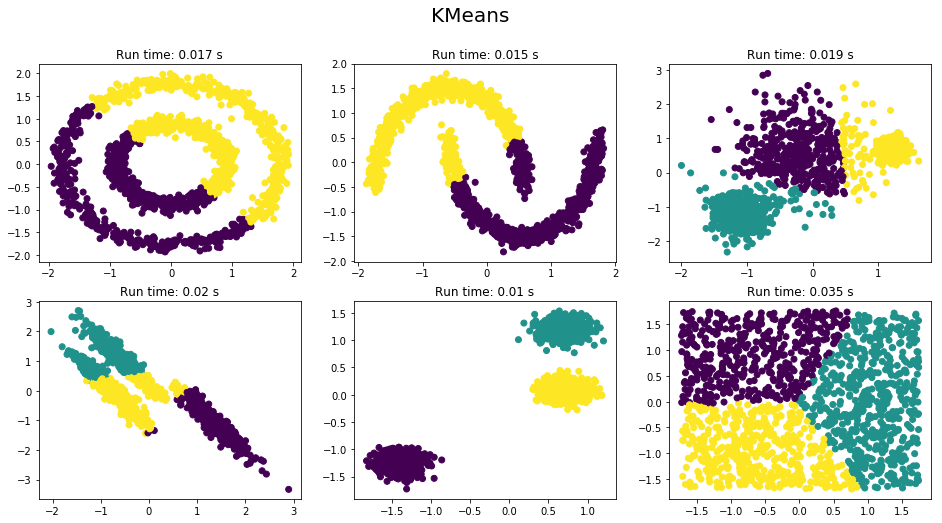

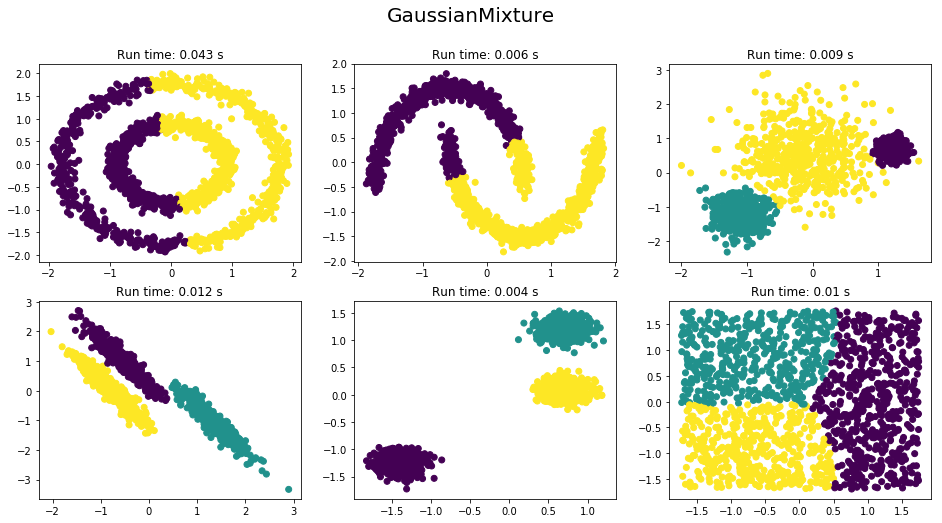

/home/adam/anaconda3/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


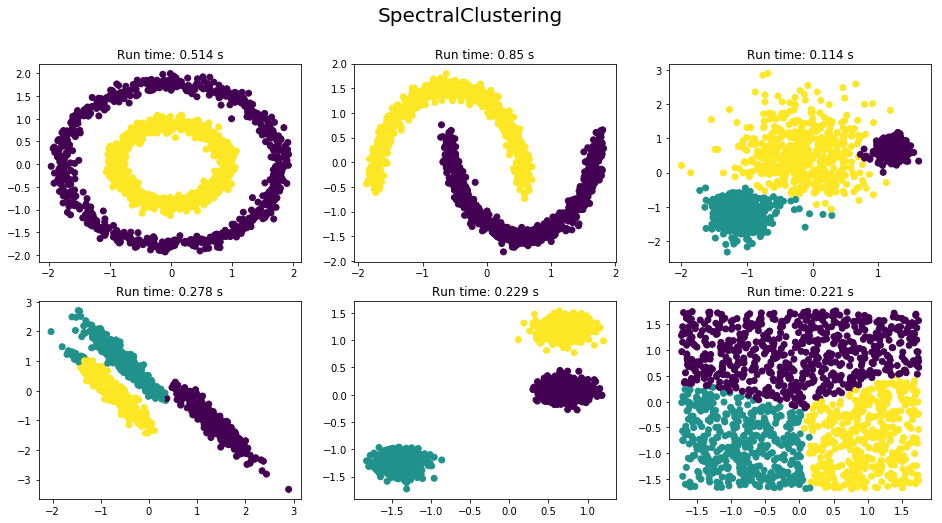

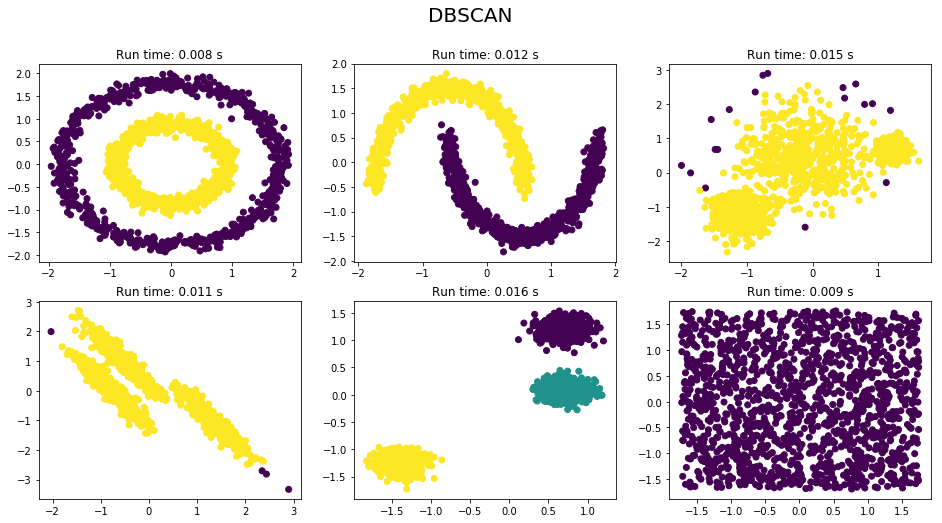

In [6]:
# update parameters with dataset-specific values
params = default_base.copy()

# ============
# Create cluster objects
# ============
kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
gmm = mixture.GaussianMixture(
    n_components=params['n_clusters'], covariance_type='full')
dbscan = cluster.DBSCAN(eps=.3)
spectral = cluster.SpectralClustering(
    n_clusters=params['n_clusters'], eigen_solver='arpack',
    affinity="nearest_neighbors")

clustering_algorithms = (
    ('KMeans', kmeans),
    ('GaussianMixture', gmm),
    ('SpectralClustering', spectral),
    ('DBSCAN', dbscan)
) 

for i in range(len(clustering_algorithms)):
    name, _ = clustering_algorithms[i]
    
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16,8))
    plt.suptitle(name, size=20)
    for i_dataset, (dataset, algo_params) in enumerate(datasets):
        params = default_base.copy()
        params.update(algo_params)       
        #
        kmeans = cluster.KMeans(n_clusters=params['n_clusters'])
        gmm = mixture.GaussianMixture(
            n_components=params['n_clusters'], covariance_type='full')
        dbscan = cluster.DBSCAN(eps=.3)
        spectral = cluster.SpectralClustering(
            n_clusters=params['n_clusters'], eigen_solver='arpack',
            affinity="nearest_neighbors")

        clustering_algorithms = (
            ('KMeans', kmeans),
            ('GaussianMixture', gmm),
            ('SpectralClustering', spectral),
            ('DBSCAN', dbscan)
        ) 
        
        _, algorithm = clustering_algorithms[i]
        
        X, y = dataset
        # normalize dataset for easier parameter selection
        X = StandardScaler().fit_transform(X)

        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()

        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)
            
        axes[i_dataset//3][i_dataset%3].scatter(X[:,0], X[:,1], c=y_pred)
        axes[i_dataset//3][i_dataset%3].set_title(f"Run time: {round(t1-t0, 3)} s")
    plt.savefig(f'{name}.png')
    plt.show()